# Exercises for chapter 8: Performance Measurement

This chapter considers how to measure the performance of the trained models.
With suﬀicient capacity (i.e., number of hidden units), a neural network model will often
perform perfectly on the training data. However, this does not necessarily mean it will
generalize well to new test data.
We will see that the test errors have three distinct causes and that their relative
contributions depend on (i) the inherent uncertainty in the task, (ii) the amount of
training data, and (iii) the choice of model. The latter dependency raises the issue of
hyperparameter search. We discuss how to select both the model hyperparameters (e.g.,
the number of hidden layers and the number of hidden units in each) and the learning
algorithm hyperparameters (e.g., the learning rate and batch size).

# Coding Exercise: MNIST 1D Performance

In [1]:
# Run this if you're in a Colab to install MNIST 1D repository
%pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /private/var/folders/12/gmswxwyn4yb5t37m7brqcy6h0000gn/T/pip-req-build-jhr0j4u6
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /private/var/folders/12/gmswxwyn4yb5t37m7brqcy6h0000gn/T/pip-req-build-jhr0j4u6
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 28.3 MB/s eta 0:00:0000:0100:01
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14665 sha256=fa079aa4f3697cf6d3f2fdc07ccdc4c1ebe212dde1333f03c119c1c06f95141f
  Stored in directory: /private/var/folders/12/gmswxwyn4yb5t37m7brqcy6h0000gn/T/pip-ephem-wheel-cache-r732l7jk/wheels/18/40/b6/29381fee9b4c80fdbc304d52bb065a7286bbcca5ca2b8737c0
Successfully built mnist1d
Note: you m

In [1]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d

/Users/stefanmenze/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Let's generate a training and test dataset using the MNIST1D code.  The dataset gets saved as a .pkl file so it doesn't have to be regenerated each time.

In [2]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
Examples in training set: 4000
Examples in test set: 4000
Length of each example: 40


In [3]:
D_i = 40    # Input dimensions
D_k = 100   # Hidden dimensions
D_o = 10    # Output dimensions
# TODO:
# Define a model with two hidden layers of size 100
# And ReLU activations between them
# Replace this line (see Figure 7.8 of book for help):
model = torch.nn.Sequential(
  torch.nn.Linear(D_i, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_k),
  torch.nn.ReLU(),
  torch.nn.Linear(D_k, D_o),
  );


def weights_init(layer_in):
  # TODO:
  # Initialize the parameters with He initialization
  # Replace this line (see figure 7.8 of book for help)
  print("Initializing layer")

  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)


# Call the function you just defined
model.apply(weights_init)


Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer


Sequential(
  (0): Linear(in_features=40, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)

The loss function is the negative log-likelihood of the training data:

$$
\begin{aligned}
L[\phi] 
&= -\sum_{i=1}^{I} \log \Big[ \text{softmax}_{y_i} \big[ \mathbf{f}[\mathbf{x}_i, \phi] \big] \Big] \\[6pt]
&= -\sum_{i=1}^{I} \left( f_{y_i}[\mathbf{x}_i, \phi] 
    - \log \left[ \sum_{k'=1}^{K} \exp \big( f_{k'}[\mathbf{x}_i, \phi] \big) \right] \right),
\end{aligned}
\tag{5.24}
$$

where $f_{y_i}[\mathbf{x}, \phi]$ and $f_{k'}[\mathbf{x}, \phi]$ denote the $y_i^{\text{th}}$ and $k'^{\text{th}}$ outputs of the network, respectively.  
For reasons that will be explained in section 5.7, this is known as the *multiclass cross-entropy loss*.

The transformed model output represents a categorical distribution over possible classes $y \in \{1, 2, \ldots, K\}$.  
For a point estimate, we take the most probable category $\hat{y} = \arg\max_k \big[ \Pr(y = k \mid \mathbf{f}[\mathbf{x}, \phi]) \big]$.  

In [9]:
# choose cross entropy loss function (equation 5.24)
loss_function = torch.nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 10 epochs
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
x_train = torch.tensor(data['x'].astype('float32'))
y_train = torch.tensor(data['y'].transpose().astype('int64'))
x_test= torch.tensor(data['x_test'].astype('float32'))
y_test = torch.tensor(data['y_test'].astype('int64'))

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

# Initialize model weights
model.apply(weights_init)

# loop over the dataset n_epoch times
n_epoch = 50
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, batch in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = batch
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch)
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train)
  pred_test = model(x_test)
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_test_class = torch.max(pred_test.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_test[epoch]= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_test[epoch]= loss_function(pred_test, y_test).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  test loss {losses_test[epoch]:.6f}, test error {errors_test[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Initializing layer
Epoch     0, train loss 1.470354, train error 54.10,  test loss 1.583562, test error 62.30
Epoch     1, train loss 1.205211, train error 43.55,  test loss 1.418883, test error 55.50
Epoch     2, train loss 1.005960, train error 35.62,  test loss 1.282904, test error 48.35
Epoch     3, train loss 0.837539, train error 29.00,  test loss 1.198555, test error 45.60
Epoch     4, train loss 0.680731, train error 22.72,  test loss 1.134857, test error 42.12
Epoch     5, train loss 0.572989, train error 18.35,  test loss 1.140976, test error 41.33
Epoch     6, train loss 0.533156, train error 18.32,  test loss 1.141295, test error 40.83
Epoch     7, train loss 0.381850, train error 10.40,  test loss 1.083630, test error 39.20
Epoch     8, train loss 0.298294, train error 7.35,  test loss 1.086296, test error 38.40
Epoch     9, train loss 0.235197, train error 6.03,  test loss 1.112

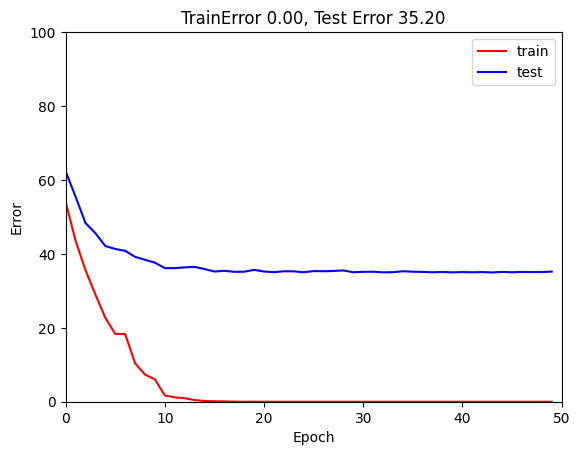

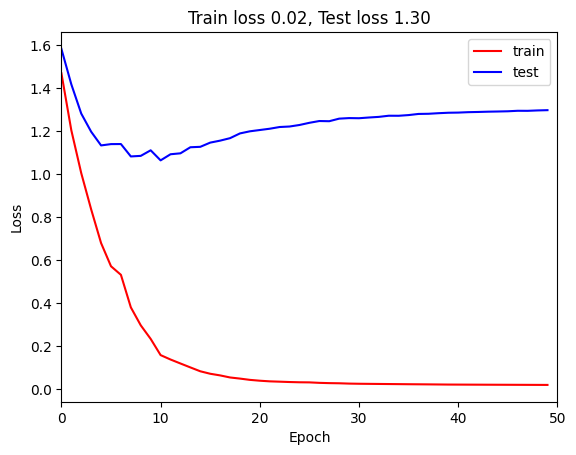

In [10]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()

**TODO**

Play with the model -- try changing the number of layers, hidden units, learning rate, batch size, momentum or anything else you like.  See if you can improve the test results.

Is it a good idea to optimize the hyperparameters in this way?  Will the final result be a good estimate of the true test performance?

# Coding Exercise: Bias-Variance Trade-Off

In [4]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

In [5]:
# Generate some data points with or without noise
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y


In [6]:
# Draw the fitted function, together with uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $y$')
    plt.show()

/var/folders/hy/_r8qgyq54bz53p1wlh4fm42w0000gn/T/ipykernel_63683/1040896329.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
/var/folders/hy/_r8qgyq54bz53p1wlh4fm42w0000gn/T/ipykernel_63683/1040896329.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


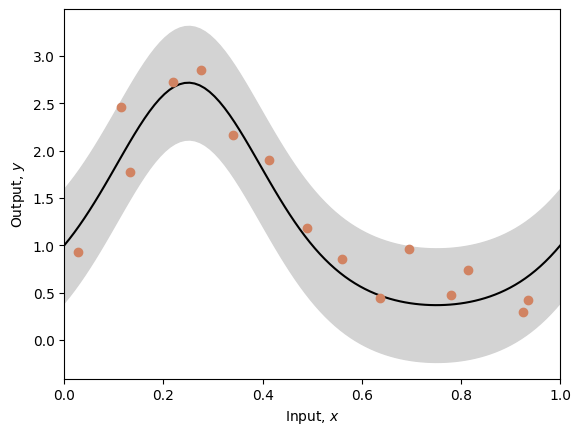

In [7]:
# Generate true function
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

# Plot the functinon, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [8]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [9]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.

def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          A[i,j] = x[i]-(j-1)/n_hidden
          if A[i,j] < 0:
              A[i,j] = 0;

  beta_omega = np.linalg.lstsq(A, y, rcond=None)[0]

  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega


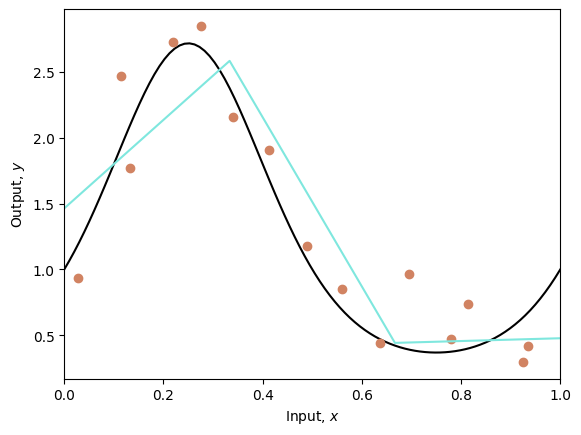

In [10]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

In [11]:
# Run the model many times with different datasets and return the mean and variance
def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func):

  # Create array that stores model results in rows
  y_model_all = np.zeros((n_datasets, x_model.shape[0]))

  for c_dataset in range(n_datasets):
    # TODO -- Generate n_data x,y, pairs with standard deviation sigma_func
    # Replace this line
    # x_data,y_data = np.zeros([1,n_data]),np.zeros([1,n_data])
    x_data, y_data = generate_data(n_data, sigma_func)

    # TODO -- Fit the model
    # Replace this line:
    # beta = 0; omega = np.zeros([n_hidden,1])
    beta, omega = fit_model_closed_form(x_data, y_data, n_hidden)

    # TODO -- Run the fitted model on x_model
    # Replace this line
    # y_model = np.zeros_like(x_model);
    y_model = network(x_model, beta, omega)
    
    # Store the model results
    y_model_all[c_dataset,:] = y_model

  # Get mean and standard deviation of model
  mean_model = np.mean(y_model_all,axis=0)
  std_model = np.std(y_model_all,axis=0)

  # Return the mean and standard deviation of the fitted model
  return mean_model, std_model

/var/folders/hy/_r8qgyq54bz53p1wlh4fm42w0000gn/T/ipykernel_63683/1040896329.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
/var/folders/hy/_r8qgyq54bz53p1wlh4fm42w0000gn/T/ipykernel_63683/1040896329.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


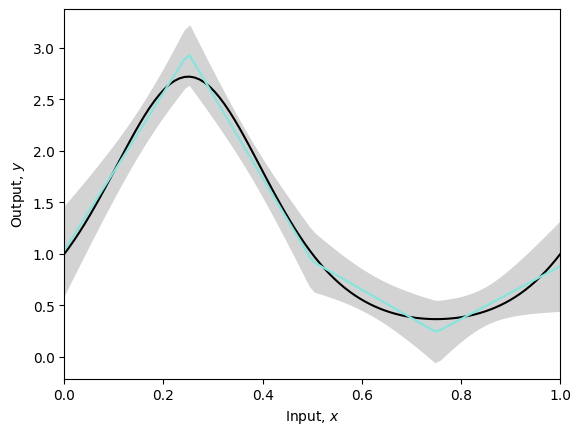

In [12]:
# Let's generate N random data sets, fit the model N times and look the mean and variance
n_datasets = 100
n_data = 30
sigma_func = 0.3
n_hidden = 4

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func) ;

# Plot the results
plot_function(x_func, y_func, x_model=x_model, y_model=mean_model, sigma_model=std_model)

In [18]:
# TODO -- Experiment with changing the number of data points and the number of hidden variables
# in the model.  Get a feeling for what happens in terms of the bias (squared deviation between cyan and black lines)
# and the variance (gray region) as we manipulate these quantities.

/var/folders/hy/_r8qgyq54bz53p1wlh4fm42w0000gn/T/ipykernel_63683/1040896329.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)
/var/folders/hy/_r8qgyq54bz53p1wlh4fm42w0000gn/T/ipykernel_63683/1040896329.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] += np.random.normal(0, sigma_y, 1)


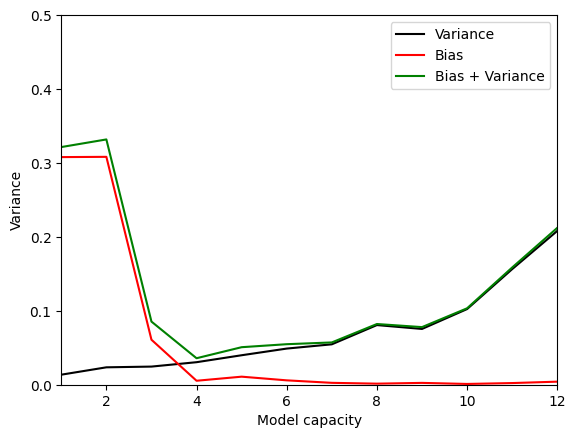

In [20]:
# Plot the noise, bias and variance as a function of capacity
n_hidden = 12
hidden_variables = list(range(1, n_hidden + 1))
bias = np.zeros((len(hidden_variables),1)) ;
variance = np.zeros((len(hidden_variables),1)) ;
# Plot the noise, bias and variance as a function of capacity

n_datasets = 100
n_data = 15
sigma_func = 0.3
#n_hidden = 5

# Set random seed so that we get the same result every time
np.random.seed(1)

for c_hidden in range(len(hidden_variables)):
  # Get mean and variance of fitted model
  mean_model, std_model = get_model_mean_variance(n_data, n_datasets, hidden_variables[c_hidden], sigma_func) ;
  # TODO -- Estimate bias and variance
  # Replace these lines

  # --- Compute variance: average of the model variance ---
  variance[c_hidden] = np.mean(std_model**2)

  # --- Compute bias: average squared error of the mean predictor vs. true function ---
  bias[c_hidden] = np.mean((mean_model - y_func)**2)

# Plot the results
fig,ax = plt.subplots()
ax.plot(hidden_variables, variance, 'k-')
ax.plot(hidden_variables, bias, 'r-')
ax.plot(hidden_variables, variance+bias, 'g-')
ax.set_xlim(1,n_hidden)
ax.set_ylim(0,0.5)
ax.set_xlabel("Model capacity")
ax.set_ylabel("Variance")
ax.legend(['Variance', 'Bias', 'Bias + Variance'])
plt.show()


# Coding Exercise: Double Descent

In [21]:
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import mnist1d
import random
random.seed(0)

In [22]:
args = mnist1d.data.get_dataset_args()
args.num_samples = 8000
args.train_split = 0.5
args.corr_noise_scale = 0.25
args.iid_noise_scale=2e-2
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=True)

# Add 15% noise to training labels
for c_y in range(len(data['y'])):
    random_number = random.random()
    if random_number < 0.15 :
        random_int = int(random.random() * 10)
        data['y'][c_y] = random_int

# The training and test input and outputs are in
# data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Dimensionality of each example: {}".format(data['x'].shape[-1]))

Did or could not load data from ./mnist1d_data.pkl. Rebuilding dataset...
Examples in training set: 4000
Examples in test set: 4000
Dimensionality of each example: 40


In [23]:
# Initialize the parameters with He initialization
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

# Return an initialized model with two hidden layers and n_hidden hidden units at each
def get_model(n_hidden):

  D_i = 40    # Input dimensions
  D_k = n_hidden   # Hidden dimensions
  D_o = 10    # Output dimensions

  # Define a model with two hidden layers
  # And ReLU activations between them
  model = nn.Sequential(
  nn.Linear(D_i, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_k),
  nn.ReLU(),
  nn.Linear(D_k, D_o))

  # Call the function you just defined
  model.apply(weights_init)

  # Return the model
  return model ;

In [24]:
def fit_model(model, data, n_epoch):

  # choose cross entropy loss function (equation 5.24)
  loss_function = torch.nn.CrossEntropyLoss()
  # construct SGD optimizer and initialize learning rate and momentum
  # optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)


  x_train = torch.tensor(data['x'].astype('float32'))
  y_train = torch.tensor(data['y'].transpose().astype('long'))
  x_test= torch.tensor(data['x_test'].astype('float32'))
  y_test = torch.tensor(data['y_test'].astype('long'))

  # load the data into a class that creates the batches
  data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))

  for epoch in range(n_epoch):
    # loop over batches
    for i, batch in enumerate(data_loader):
      # retrieve inputs and labels for this batch
      x_batch, y_batch = batch
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward pass -- calculate model output
      pred = model(x_batch)
      # compute the loss
      loss = loss_function(pred, y_batch)
      # backward pass
      loss.backward()
      # SGD update
      optimizer.step()

    # Run whole dataset to get statistics -- normally wouldn't do this
    pred_train = model(x_train)
    pred_test = model(x_test)
    _, predicted_train_class = torch.max(pred_train.data, 1)
    _, predicted_test_class = torch.max(pred_test.data, 1)
    errors_train = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
    errors_test= 100 - 100 * (predicted_test_class == y_test).float().sum() / len(y_test)
    losses_train = loss_function(pred_train, y_train).item()
    losses_test= loss_function(pred_test, y_test).item()
    if epoch%100 ==0 :
      print(f'Epoch {epoch:5d}, train loss {losses_train:.6f}, train error {errors_train:3.2f},  test loss {losses_test:.6f}, test error {errors_test:3.2f}')

  return errors_train, errors_test


In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The following code produces the double descent curve by training the model with different numbers of hidden units and plotting the test error.

TODO:

*Before* you run the code, and considering that there are 4000 training examples predict:<br>

1.    At what capacity do you think the training error will become zero?
2.   At what capacity do you expect the first minima of the double descent curve to appear?
3. At what capacity do you expect the maximum of the double descent curve to appear?

In [26]:
# This code will take a while (~15 mins) to run!  Go and make a cup of coffee!

hidden_variables = np.array([2,4,6,8,10,14,18,22,26,30,35,40,45,50,55,60,70,80,90,100,120,140,160,180,200,250,300,400]) ;

errors_train_all = np.zeros_like(hidden_variables)
errors_test_all = np.zeros_like(hidden_variables)
total_weights_all = np.zeros_like(hidden_variables)

# loop over the dataset n_epoch times
n_epoch = 1000

# For each hidden variable size
for c_hidden in range(len(hidden_variables)):
    print(f'Training model with {hidden_variables[c_hidden]:3d} hidden variables')
    # Get a model
    model = get_model(hidden_variables[c_hidden]) ;
    # Count and store number of weights
    total_weights_all[c_hidden] = count_parameters(model)
    # Train the model
    errors_train, errors_test = fit_model(model, data, n_epoch)
    # Store the results
    errors_train_all[c_hidden] = errors_train
    errors_test_all[c_hidden]= errors_test



Training model with   2 hidden variables
Epoch     0, train loss 2.299970, train error 89.22,  test loss 2.300503, test error 90.00
Epoch   100, train loss 1.910451, train error 72.32,  test loss 1.758214, test error 70.70
Epoch   200, train loss 1.904456, train error 71.55,  test loss 1.747500, test error 70.55
Epoch   300, train loss 1.900652, train error 71.55,  test loss 1.740746, test error 69.75
Epoch   400, train loss 1.901397, train error 72.20,  test loss 1.733204, test error 70.03
Epoch   500, train loss 1.899230, train error 71.60,  test loss 1.738204, test error 68.97
Epoch   600, train loss 1.898571, train error 71.45,  test loss 1.735676, test error 69.50
Epoch   700, train loss 1.900220, train error 71.15,  test loss 1.745282, test error 69.30
Epoch   800, train loss 1.899209, train error 71.85,  test loss 1.731710, test error 69.70
Epoch   900, train loss 1.897829, train error 71.32,  test loss 1.735279, test error 69.47
Training model with   4 hidden variables
Epoch   

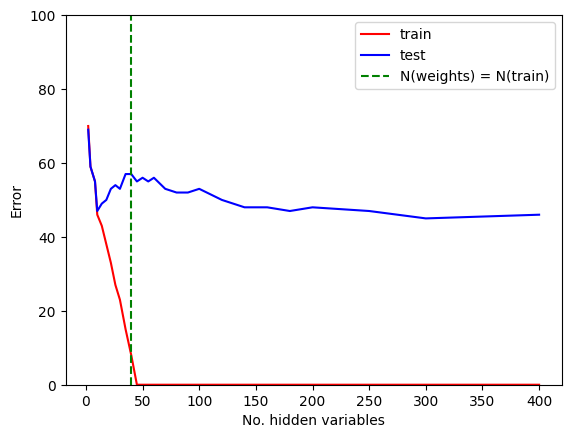

In [27]:

# Assuming data['y'] is available and contains the training examples
num_training_examples = len(data['y'])

# Find the index where total_weights_all is closest to num_training_examples
closest_index = np.argmin(np.abs(np.array(total_weights_all) - num_training_examples))

# Get the corresponding value of hidden variables
hidden_variable_at_num_training_examples = hidden_variables[closest_index]

# Plot the results
fig, ax = plt.subplots()
ax.plot(hidden_variables, errors_train_all, 'r-', label='train')
ax.plot(hidden_variables, errors_test_all, 'b-', label='test')

# Add a vertical line at the point where total weights equal the number of training examples
ax.axvline(x=hidden_variable_at_num_training_examples, color='g', linestyle='--', label='N(weights) = N(train)')

ax.set_ylim(0, 100)
ax.set_xlabel('No. hidden variables')
ax.set_ylabel('Error')
ax.legend()
plt.show()
